In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 设置日志级别为ERROR，以减少警告信息
# 禁用 Gemini 的底层库（gRPC 和 Abseil）在初始化日志警告
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "3"  # 0: INFO, 1: WARNING, 2: ERROR, 3: FATAL
os.environ["GLOG_minloglevel"] = "true"
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!export TF_FORCE_GPU_ALLOW_GROWTH=true

In [2]:
# Copyright 2018 The TensorFlow Authors.
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 基本分类：对服装图像进行分类

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本指南将训练一个神经网络模型，对运动鞋和衬衫等服装图像进行分类。即使您不理解所有细节也没关系；这只是对完整 TensorFlow 程序的快速概述，详细内容会在您实际操作的同时进行介绍。

本指南使用了 [tf.keras](https://tensorflow.google.cn/guide/keras)，它是 TensorFlow 中用来构建和训练模型的高级 API。

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.17.0


## 导入 Fashion MNIST 数据集

本指南使用 [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集，该数据集包含 10 个类别的 70,000 个灰度图像。这些图像以低分辨率（28x28 像素）展示了单件衣物，如下所示：

<table>
  <tr><td>     <img alt="Fashion MNIST sprite" src="https://tensorflow.google.cn/images/fashion-mnist-sprite.png"> </td></tr>
  <tr><td align="center">     <b>图 1.</b>  <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST 样本</a>（由 Zalando 提供，MIT 许可）。<br> </td></tr>
</table>

Fashion MNIST 旨在临时替代经典 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据集，后者常被用作计算机视觉机器学习程序的“Hello, World”。MNIST 数据集包含手写数字（0、1、2 等）的图像，其格式与您将使用的衣物图像的格式相同。

本指南使用 Fashion MNIST 来实现多样化，因为它比常规 MNIST 更具挑战性。这两个数据集都相对较小，都用于验证某个算法是否按预期工作。对于代码的测试和调试，它们都是很好的起点。

在本指南中，我们使用 60,000 张图像来训练网络，使用 10,000 张图像来评估网络学习对图像进行分类的准确程度。您可以直接从 TensorFlow 中访问 Fashion MNIST。直接从 TensorFlow 中导入和加载 Fashion MNIST 数据：

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

加载数据集会返回四个 NumPy 数组：

- `train_images` 和 `train_labels` 数组是*训练集*，即模型用于学习的数据。
- *测试集*、`test_images` 和 `test_labels` 数组会被用来对模型进行测试。

图像是 28x28 的 NumPy 数组，像素值介于 0 到 255 之间。*标签*是整数数组，介于 0 到 9 之间。这些标签对应于图像所代表的服装*类*：

<table>
  <tr>
    <th>标签</th>
    <th>类</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T恤/上衣</td>
  </tr>
  <tr>
    <td>1</td>
    <td>裤子</td>
  </tr>
    <tr>
    <td>2</td>
    <td>套头衫</td>
  </tr>
    <tr>
    <td>3</td>
    <td>连衣裙</td>
  </tr>
    <tr>
    <td>4</td>
    <td>外套</td>
  </tr>
    <tr>
    <td>5</td>
    <td>凉鞋</td>
  </tr>
    <tr>
    <td>6</td>
    <td>衬衫</td>
  </tr>
    <tr>
    <td>7</td>
    <td>运动鞋</td>
  </tr>
    <tr>
    <td>8</td>
    <td>包</td>
  </tr>
    <tr>
    <td>9</td>
    <td>短靴</td>
  </tr>
</table>

每个图像都会被映射到一个标签。由于数据集不包括*类名称*，请将它们存储在下方，供稍后绘制图像时使用：

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 浏览数据

在训练模型之前，我们先浏览一下数据集的格式。以下代码显示训练集中有 60,000 个图像，每个图像由 28 x 28 的像素表示：

In [7]:
train_images.shape

(60000, 28, 28)

同样，训练集中有 60,000 个标签：

In [8]:
len(train_labels)

60000

每个标签都是一个 0 到 9 之间的整数：

In [9]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

测试集中有 10,000 个图像。同样，每个图像都由 28x28 个像素表示：

In [10]:
test_images.shape

(10000, 28, 28)

测试集包含 10,000 个图像标签：

In [11]:
len(test_labels)

10000

## 预处理数据

在训练网络之前，必须对数据进行预处理。如果您检查训练集中的第一个图像，您会看到像素值处于 0 到 255 之间：

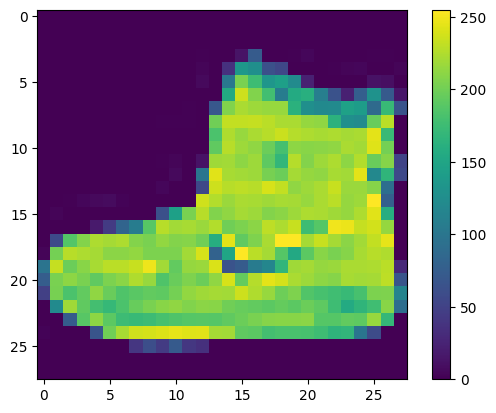

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

将这些值缩小至 0 到 1 之间，然后将其馈送到神经网络模型。为此，请将这些值除以 255。请务必以相同的方式对*训练集*和*测试集*进行预处理：

In [13]:
train_images = train_images / 255.0

test_images = test_images / 255.0

为了验证数据的格式是否正确，以及您是否已准备好构建和训练网络，让我们显示*训练集*中的前 25 个图像，并在每个图像下方显示类名称。

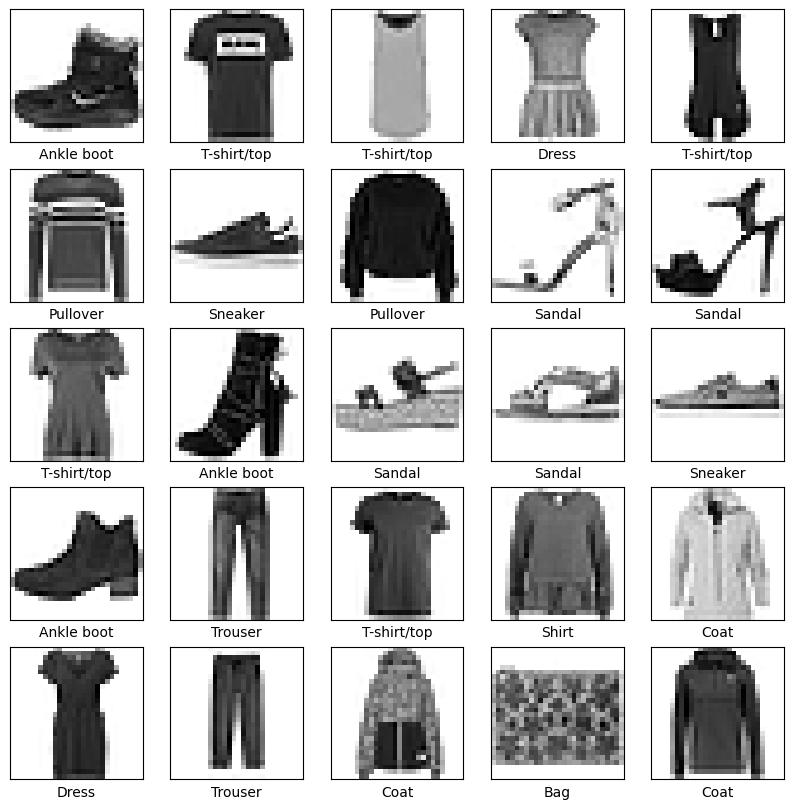

In [14]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 构建模型

构建神经网络需要先配置模型的层，然后再编译模型。

### 设置层

神经网络的基本组成部分是<em>层</em>。层会从向其馈送的数据中提取表示形式。希望这些表示形式有助于解决手头上的问题。

大多数深度学习都包括将简单的层链接在一起。大多数层（如 {class}`tensorflow.keras.layers.Dense`）都具有在训练期间才会学习的参数。

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

该网络的第一层 {class}`tensorflow.keras.layers.Flatten` 将图像格式从二维数组（28 x 28 像素）转换成一维数组（28 x 28 = 784 像素）。将该层视为图像中未堆叠的像素行并将其排列起来。该层没有要学习的参数，它只会重新格式化数据。

展平像素后，网络会包括两个 {class}`tensorflow.keras.layers.Dense` 层的序列。它们是密集连接或全连接神经层。第一个 `Dense` 层有 128 个节点（或神经元）。第二个（也是最后一个）层会返回一个长度为 10 的 logits 数组。每个节点都包含一个得分，用来表示当前图像属于 10 个类中的哪一类。

### 编译模型

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的<em>编译</em>步骤中添加的：

- <em>损失函数</em> - 测量模型在训练期间的准确程度。你希望最小化此函数，以便将模型“引导”到正确的方向上。
- <em>优化器</em> - 决定模型如何根据其看到的数据和自身的损失函数进行更新。
- <em>指标</em> - 用于监控训练和测试步骤。以下示例使用了*准确率*，即被正确分类的图像的比率。

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 训练模型

训练神经网络模型需要执行以下步骤：

1. 将训练数据馈送给模型。在本例中，训练数据位于 `train_images` 和 `train_labels` 数组中。
2. 模型学习将图像和标签关联起来。
3. 要求模型对测试集（在本例中为 `test_images` 数组）进行预测。
4. 验证预测是否与 `test_labels` 数组中的标签相匹配。


### 向模型馈送数据

要开始训练，请调用 <code>model.fit</code> 方法，这样命名是因为该方法会将模型与训练数据进行“拟合”：

In [17]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


I0000 00:00:1729736509.779215 3208907 service.cc:146] XLA service 0x7f4dfc01b500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729736509.779287 3208907 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1729736509.779300 3208907 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


  74/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4871 - loss: 1.4441    

I0000 00:00:1729736513.497273 3208907 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7771 - loss: 0.6364
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8618 - loss: 0.3829
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8774 - loss: 0.3358
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8860 - loss: 0.3124
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8899 - loss: 0.2986
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8965 - loss: 0.2785
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9030 - loss: 0.2657
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9058 - loss: 0.2536
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9098 - loss: 0.2427
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9118 - loss: 0.2340


在模型训练期间，会显示损失和准确率指标。此模型在训练数据上的准确率达到了 0.91（或 91%）左右。

### 评估准确率

接下来，比较模型在测试数据集上的表现：

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 6ms/step - accuracy: 0.8796 - loss: 0.3494

Test accuracy: 0.8795999884605408


结果表明，模型在测试数据集上的准确率略低于训练数据集。训练准确率和测试准确率之间的差距代表*过拟合*。过拟合是指机器学习模型在新的、以前未曾见过的输入上的表现不如在训练数据上的表现。过拟合的模型会“记住”训练数据集中的噪声和细节，从而对模型在新数据上的表现产生负面影响。有关更多信息，请参阅以下内容：

- [演示过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
- [防止过拟合的策略](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### 进行预测

模型经过训练后，您可以使用它对一些图像进行预测。附加一个 Softmax 层，将模型的线性输出 [logits](https://developers.google.com/machine-learning/glossary#logits) 转换成更容易理解的概率。

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [20]:
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


在上例中，模型预测了测试集中每个图像的标签。我们来看看第一个预测结果：

In [21]:
predictions[0]

array([1.6527409e-08, 1.4129248e-09, 2.2416434e-10, 8.0054169e-10,
       3.7958323e-08, 8.9384953e-04, 2.1727022e-08, 1.2796247e-02,
       3.7120977e-08, 9.8630977e-01], dtype=float32)

预测结果是一个包含 10 个数字的数组。它们代表模型对 10 种不同服装中每种服装的“置信度”。您可以看到哪个标签的置信度值最大：

In [22]:
np.argmax(predictions[0])

9

因此，该模型非常确信这个图像是短靴，或 `class_names[9]`。通过检查测试标签发现这个分类是正确的：

In [23]:
test_labels[0]

9

您可以将其绘制成图表，看看模型对于全部 10 个类的预测。

In [24]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 验证预测结果

在模型经过训练后，您可以使用它对一些图像进行预测。

我们来看看第 0 个图像、预测结果和预测数组。正确的预测标签为蓝色，错误的预测标签为红色。数字表示预测标签的百分比（总计为 100）。

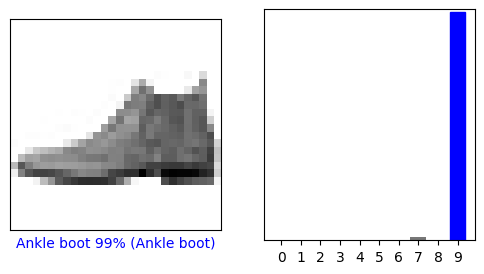

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

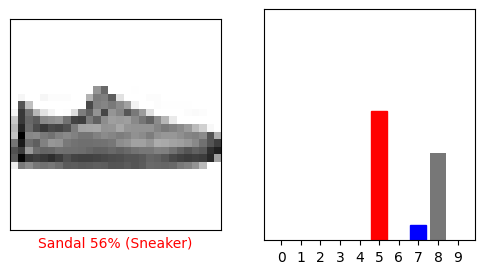

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

让我们用模型的预测绘制几张图像。请注意，即使置信度很高，模型也可能出错。

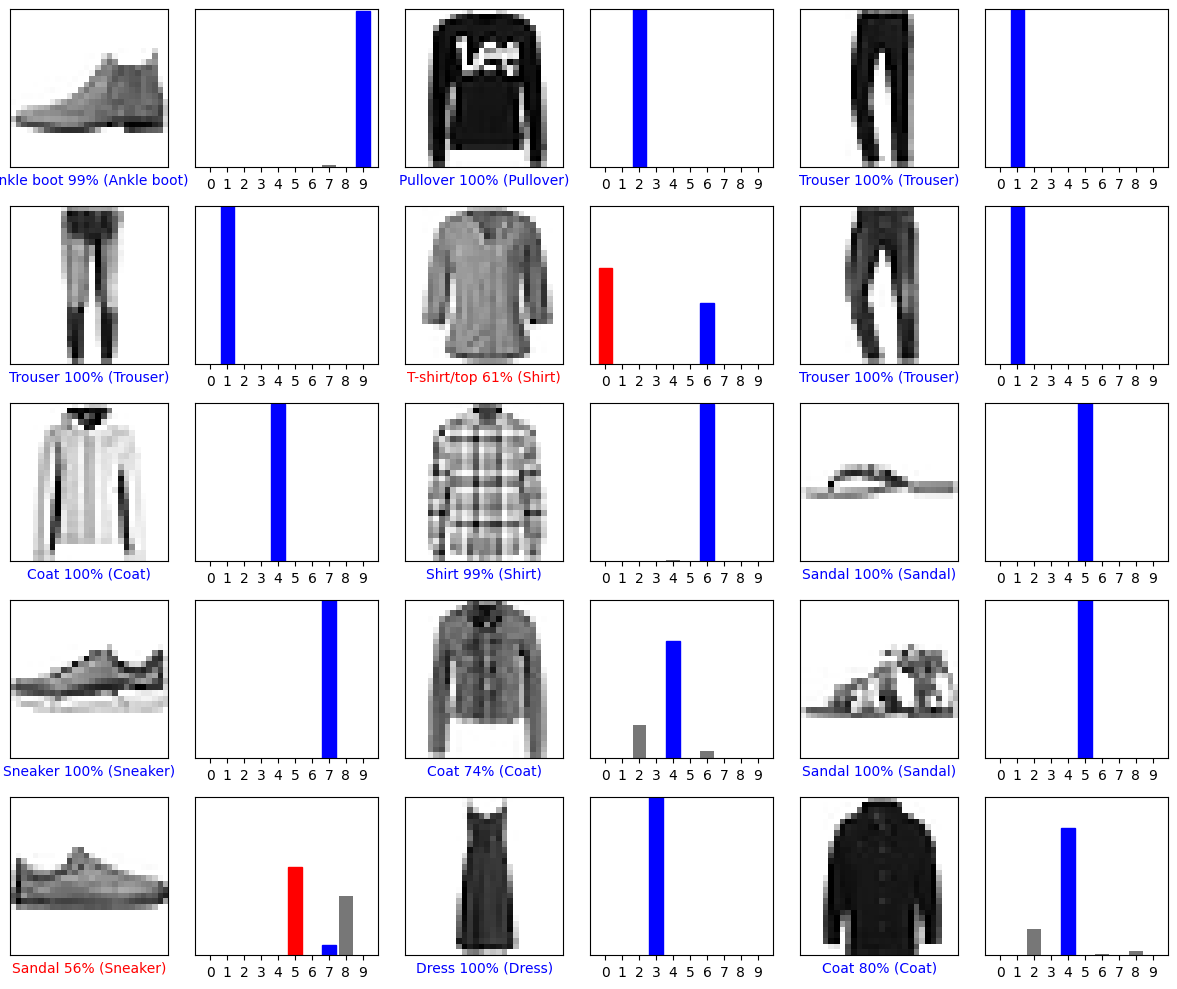

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 使用训练好的模型

最后，使用训练好的模型对单个图像进行预测。

In [28]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` 模型经过了优化，可同时对一个*批*或一组样本进行预测。因此，即便您只使用一个图像，您也需要将其添加到列表中：

In [29]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


现在预测这个图像的正确标签：

In [30]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[3.28207592e-04 2.89583964e-11 9.99377131e-01 1.29967814e-10
  1.93019659e-04 2.80547027e-11 1.01659716e-04 2.54715407e-16
  1.74937620e-09 1.95157475e-12]]


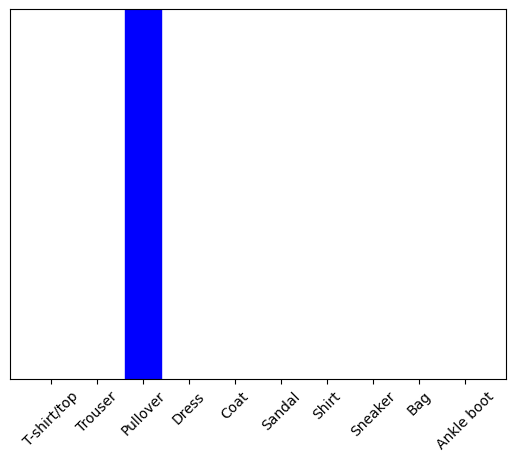

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`keras.Model.predict` 会返回一组列表，每个列表对应一批数据中的每个图像。在批次中获取对我们（唯一）图像的预测：

In [32]:
np.argmax(predictions_single[0])

2

该模型会按照预期预测标签。